In [1]:
from dotenv import load_dotenv
import os
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

load_dotenv()

True

In [2]:
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

e:\2025\Generative_AI\Course\agentic-ai-2.0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result = embeddings.embed_query("hello")
len(result)

384

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity is normalized - range (-1, 1)

In [6]:
documents = [
    "who is the president of USA?",
    "what is the capital of india",
    "who is the prime minister of india?"
]

In [7]:
my_query = "Narendra Modhi is the prime minister of india?"

In [12]:
doc_embedding = embeddings.embed_documents(documents)
len(doc_embedding)

3

In [10]:
query_embedding = embeddings.embed_query(my_query)

In [14]:
cosine_similarity([query_embedding], doc_embedding)

array([[0.39365335, 0.31266522, 0.7991942 ]])

In [18]:
from sklearn.metrics.pairwise import euclidean_distances

# Euclidean distance is not normalized (L2 Distance) we should take lowest distance

In [16]:
euclidean_distances([query_embedding], doc_embedding)

array([[1.10122352, 1.172463  , 0.63372831]])

- Cosine similariry [-1, 1] Focuses on angle only
- L2 Distance (Euclidean distance) [0, infinity] Focus on magnitude + direction

In [21]:
import faiss 
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [23]:
index = faiss.IndexFlatL2(384)

In [27]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [30]:
vector_store.add_texts(["AI is the future", "I love dogs", "Expert AI Enggineer"])

['16605fb9-42a1-47c3-9935-4d519ccbe3ce',
 'e8ebd5ab-a576-4422-95ac-f1d81bb714b7',
 '0476a43b-c991-4516-af4a-2cb3ea3d473d']

In [32]:
vector_store.index_to_docstore_id

{0: '16605fb9-42a1-47c3-9935-4d519ccbe3ce',
 1: 'e8ebd5ab-a576-4422-95ac-f1d81bb714b7',
 2: '0476a43b-c991-4516-af4a-2cb3ea3d473d'}

In [34]:
results = vector_store.similarity_search("Tell me about AI", k=2)
results

[Document(id='16605fb9-42a1-47c3-9935-4d519ccbe3ce', metadata={}, page_content='AI is the future'),
 Document(id='0476a43b-c991-4516-af4a-2cb3ea3d473d', metadata={}, page_content='Expert AI Enggineer')]

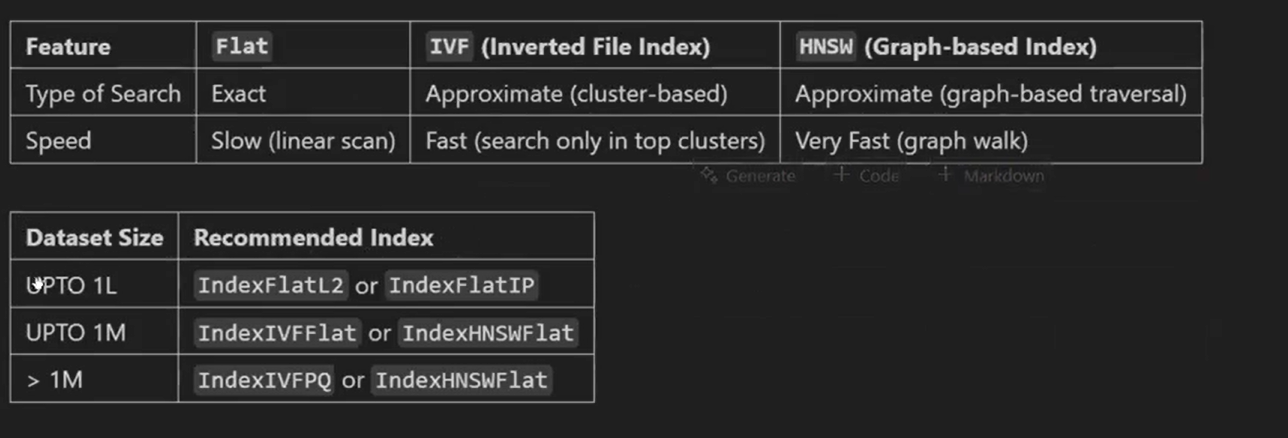

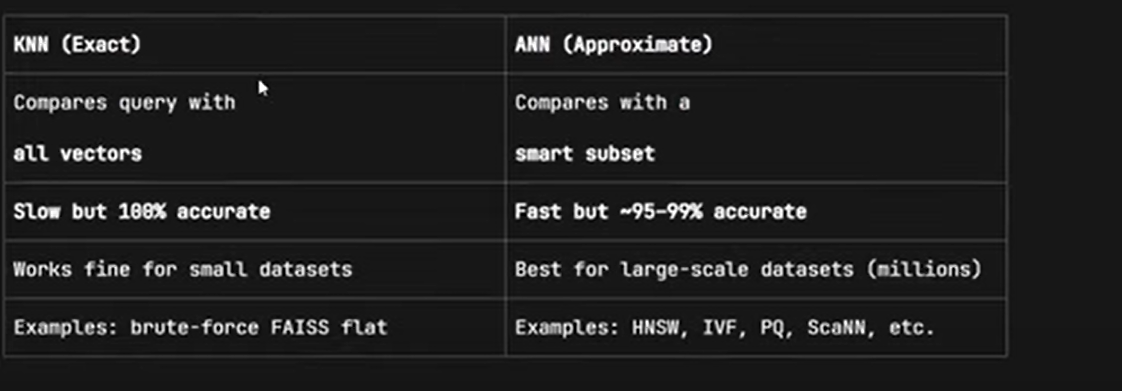

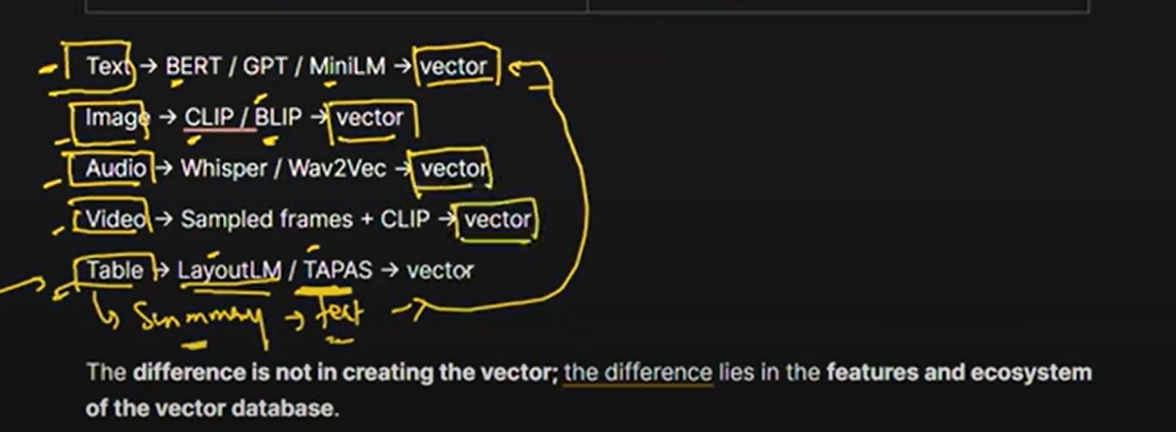

In [39]:
from langchain_core.documents import Document

document1 = Document(
    page_content="I had choco chips, pancakes and scrumbles for breakfast this morning",
    metadata={"source": "tweet"}
)

document2 = Document(
    page_content="The weather forcast for tomorrow is cloudy, with a high 62 degree",
    metadata={"source": "news"}
)

document3 = Document(
    page_content="Building an exiting langchain project - come check out",
    metadata={"source": "tweet"}
)

document4 = Document(
    page_content="Robber broke into the city bank and stole $1 million in cash",
    metadata={"source": "news"}
)

documents = [
    document1,
    document2,
    document3,
    document4
]

- index = faiss.IndexFlatL2 # L2 distance -> for euclidean distance
- index = faiss.IndexFlatIP  # Inner product -> for cosine similarity

In [42]:
# index = faiss.IndexFlatL2() # L2 distance -> for euclidean distance
index = faiss.IndexFlatIP(384)  # Inner product -> for cosine similarity

vector_store = FAISS(
    embedding_function=embeddings,
    docstore=InMemoryDocstore(),
    index=index,
    index_to_docstore_id={}
)

In [43]:
vector_store.add_documents(documents=documents)

['5ea19057-7961-4849-aac7-406812014f8b',
 '10146c9f-aab0-44a0-b74f-361ed47d8b8e',
 'b4fb32c2-a835-40cd-88ad-6f8bc1959333',
 '6fb4f5ec-897a-46ac-9f0a-0ab87040edd9']

In [46]:
vector_store.similarity_search("what breakfas i had?", k=2, filter={"source": {"$eq": "tweet"}})

[Document(id='5ea19057-7961-4849-aac7-406812014f8b', metadata={'source': 'tweet'}, page_content='I had choco chips, pancakes and scrumbles for breakfast this morning'),
 Document(id='b4fb32c2-a835-40cd-88ad-6f8bc1959333', metadata={'source': 'tweet'}, page_content='Building an exiting langchain project - come check out')]

In [47]:
vector_store.similarity_search("what breakfas i had?", k=2, filter={"source": "news"})

[Document(id='6fb4f5ec-897a-46ac-9f0a-0ab87040edd9', metadata={'source': 'news'}, page_content='Robber broke into the city bank and stole $1 million in cash'),
 Document(id='10146c9f-aab0-44a0-b74f-361ed47d8b8e', metadata={'source': 'news'}, page_content='The weather forcast for tomorrow is cloudy, with a high 62 degree')]

In [49]:
result = vector_store.similarity_search("what breakfas i had?", k=2, filter={"source": "news"})

result[0].metadata

{'source': 'news'}

In [53]:
retriever = vector_store.as_retriever(search_kwargs={"k": 2})

In [54]:
retriever.invoke("which breakfast i had")

[Document(id='5ea19057-7961-4849-aac7-406812014f8b', metadata={'source': 'tweet'}, page_content='I had choco chips, pancakes and scrumbles for breakfast this morning'),
 Document(id='6fb4f5ec-897a-46ac-9f0a-0ab87040edd9', metadata={'source': 'news'}, page_content='Robber broke into the city bank and stole $1 million in cash')]

#### on disk

In [55]:
vector_store.save_local("faiss index")

In [57]:
new_vector_store = FAISS.load_local(
    "faiss index", embeddings, allow_dangerous_deserialization=True
    )

In [58]:
new_retriever = new_vector_store.as_retriever(search_kwargs={"k": 2})

In [59]:
new_retriever.invoke("what breakfast i had")

[Document(id='5ea19057-7961-4849-aac7-406812014f8b', metadata={'source': 'tweet'}, page_content='I had choco chips, pancakes and scrumbles for breakfast this morning'),
 Document(id='10146c9f-aab0-44a0-b74f-361ed47d8b8e', metadata={'source': 'news'}, page_content='The weather forcast for tomorrow is cloudy, with a high 62 degree')]

In [61]:
res = new_retriever.invoke("what breakfast i had")

res[0].metadata

{'source': 'tweet'}

#### RAG

In [68]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
import os 
from dotenv import load_dotenv

load_dotenv()

True

In [63]:
file_path = r"E:\2025\Generative_AI\Course\agentic-ai-2.0\data\syllabus.pdf"
docs = PyPDFLoader(file_path).load()
len(docs)

34

In [64]:
docs[0]

Document(metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2025-01-30T20:27:03+00:00', 'title': 'Ultimate Data Science & GenAI Bootcamp', 'moddate': '2025-01-30T20:26:59+00:00', 'keywords': 'DAGdmhcqnYw,BAEmsmap8Lg,0', 'author': 'monal singh', 'containsaigeneratedcontent': 'Yes', 'source': 'E:\\2025\\Generative_AI\\Course\\agentic-ai-2.0\\data\\syllabus.pdf', 'total_pages': 34, 'page': 0, 'page_label': '1'}, page_content='MACHINE\nLEARNING\nDEEP\nLEARNING\nPYTHON +\nSTATS\nCOMPUTER VISIONNATURAL LANGUAGE PROCESSING\nGENERATIVE AI\nRETRIEVAL AUGUMENT GENERATION\nVECTOR DB')

In [65]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
documents = text_splitter.split_documents(docs)
len(documents)

53

In [66]:
documents[0]

Document(metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2025-01-30T20:27:03+00:00', 'title': 'Ultimate Data Science & GenAI Bootcamp', 'moddate': '2025-01-30T20:26:59+00:00', 'keywords': 'DAGdmhcqnYw,BAEmsmap8Lg,0', 'author': 'monal singh', 'containsaigeneratedcontent': 'Yes', 'source': 'E:\\2025\\Generative_AI\\Course\\agentic-ai-2.0\\data\\syllabus.pdf', 'total_pages': 34, 'page': 0, 'page_label': '1'}, page_content='MACHINE\nLEARNING\nDEEP\nLEARNING\nPYTHON +\nSTATS\nCOMPUTER VISIONNATURAL LANGUAGE PROCESSING\nGENERATIVE AI\nRETRIEVAL AUGUMENT GENERATION\nVECTOR DB')

In [67]:
embeddings = HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")

In [75]:
index = faiss.IndexFlatL2(384)

vector_store = FAISS(
    embedding_function=embeddings,
    docstore=InMemoryDocstore(),
    index=index,
    index_to_docstore_id={}
)

In [76]:
vector_store.add_documents(documents)

['11275641-460a-4d7b-9653-9153b45f6655',
 '7c5c847a-5345-4385-b43a-b5688d2aef74',
 'd0369b7b-c002-42d4-81fa-03637bc1efdd',
 '61073c78-6241-4c4f-85c9-c92a1e69dad1',
 '923db29e-4063-4dab-9ae0-18fd287ffdf4',
 '4ec529ff-50bc-46f4-9a9e-1d4ce8732ba5',
 '467bb7b2-81fb-4db8-ae5d-de65449dee3e',
 'a3cd4d22-9a12-4616-963d-a44f60d89665',
 'ad7565a6-9580-4ec4-b47f-2b252e290f55',
 '09f26cf5-9f93-4946-8d5a-51aa8382d556',
 '1e59edbf-655f-4efd-9603-d9183a824259',
 '07101c5d-c55c-44a7-a50f-aa2f4f8255ba',
 '92e0aefd-a87c-4b9a-9663-f60cf5dd4370',
 'ce9d3807-0e00-4765-abd9-b62cb0265edc',
 '2350ebb9-edc0-43ca-8b33-17169234ecfb',
 '79a6cf28-b63b-4d9f-9dda-97d1e51a0545',
 '3a35b6eb-de84-4a40-8878-cf2f300ba57e',
 '6667cb47-461e-4e20-b2a8-3edf1ff8fe2a',
 '1a7194c8-e97f-41f0-bac3-504ea3d8f360',
 'b9bd5376-7d27-4f9d-b0bf-56bda773f073',
 '5c3ab849-ff5f-4b6d-ae76-06747ef3e5e4',
 'e3bee4a6-ffba-4475-b3ce-751f4e3970b4',
 'd9a79daf-2866-4ec3-8e8c-91e81c014d8e',
 '9e28f3e0-6feb-4c70-a33b-26c2abd114f8',
 'cb885e01-dbf7-

In [77]:
vector_store.similarity_search("which python fundamentals are covered")

[Document(id='467bb7b2-81fb-4db8-ae5d-de65449dee3e', metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2025-01-30T20:27:03+00:00', 'title': 'Ultimate Data Science & GenAI Bootcamp', 'moddate': '2025-01-30T20:26:59+00:00', 'keywords': 'DAGdmhcqnYw,BAEmsmap8Lg,0', 'author': 'monal singh', 'containsaigeneratedcontent': 'Yes', 'source': 'E:\\2025\\Generative_AI\\Course\\agentic-ai-2.0\\data\\syllabus.pdf', 'total_pages': 34, 'page': 4, 'page_label': '5'}, page_content="In this module, you’ll get a solid introduction to Python, covering essential programming concepts\nsuch as variables, data types, operators, and control flow. You’ll learn how to manipulate strings,\nlists, dictionaries, and other basic data structures. The module will also guide you through writing\nsimple functions and using loops and conditionals effectively. By the end, you'll have a strong\nunderstanding of Python syntax, preparing you to tackle more complex programming challenges\nand form a foundati

In [78]:
retriever = vector_store.as_retriever()

In [92]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate(
    [
        ("system", "You are a ai assistant provide the answer based on the provided context only {context}"),
        ("user", "{query}")
    ]
)

In [82]:
from langchain_groq.chat_models import ChatGroq

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

In [83]:
from langchain_core.runnables import RunnablePassthrough, RunnableMap
from langchain_core.output_parsers import StrOutputParser

chain = ({
    "context": retriever,
    "query": RunnablePassthrough()
    }
         | prompt 
         | llm
         | StrOutputParser()
         )

In [86]:
result = chain.invoke("which python fundamentals are covered")
print(result)

The provided text states that the Python Foundations module will cover:

* **Introduction to Python:** Comparison with other programming languages, Python objects (Numbers, Booleans, and Strings) 
* **Data Structures & Operations:** Container objects and mutability, Operators, Operator precedence and associativity
* **Control Flow:** Conditional statements, Loops, break and continue statements
* **String Manipulation:** Basics of string objects, Inbuilt string operations 


Let me know if you have any other questions. 



In [94]:
prompt = ChatPromptTemplate(
    [
        ("system", "You are a ai assistant provide the answer based on the provided context only {context}"),
        ("user", "{query}")
    ]
)

chain = (RunnableMap({
    "context": retriever,
    "query": RunnablePassthrough()
    })
         | prompt 
         | llm
         | StrOutputParser()
         )

result = chain.invoke("which python fundamentals are covered")
print(result)

Based on the provided text, these Python fundamentals are covered:

* **Variables**
* **Data types**
* **Operators**
* **Control flow** (e.g., conditional statements, loops)
* **String manipulation**
* **Lists**
* **Dictionaries**
* **Functions** 


Let me know if you have any other questions.



In [95]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [97]:
prompt = ChatPromptTemplate(
    [
        ("system", "You are a ai assistant provide the answer based on the provided context only {context}"),
        ("user", "{query}")
    ]
)

chain = (
    {"context": retriever | format_docs, "query": RunnablePassthrough()}
    | prompt 
    | llm 
    | StrOutputParser()
)

result = chain.invoke("which python fundamentals are covered")
print(result)

According to the provided text, this Python module covers these fundamentals:

* **Variables**
* **Data types** (Numbers, Booleans, and Strings)
* **Operators**
* **Control flow** (Conditional statements, Loops, break and continue statements)
* **String manipulation** 


Let me know if you'd like more details on any of these topics! 



#### import prompt from hub

In [87]:
from langchain import hub 

prompt = hub.pull("rlm/rag-prompt")

In [90]:
import pprint

pprint.pprint(prompt.messages)

[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
